In [1]:
pip install mne

In [2]:
import os
import numpy as np
import mne

from sklearn.preprocessing import MinMaxScaler, StandardScaler

#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Visual
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, corrmap)
from scipy.stats import ttest_rel
from tensorflow.keras import utils as np_utils
from sklearn.utils import shuffle
import seaborn as sns

#CNN
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [3]:
dataPath = '/content/drive/MyDrive/databbci'

In [4]:
import os

active = []
passive = []
cue = []


data_number = 0
for dir in os.listdir(dataPath):
  for filename in os.listdir(os.path.join(dataPath, dir)):
    #if filename.endswith(".vhdr"):
    tmp = os.path.join(os.path.join(dataPath, dir), filename)
      #with open(os.path.join(os.path.join(dataPath, dir), filename), 'r') as f: # open in readonly mode
    if filename.endswith("active.vhdr"):
      active.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("passive.vhdr"):
      passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("cue.vhdr"):
      cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
print(len(active))

<ipython-input-4-e82f2427b298>:17: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-e82f2427b298>:15: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  active.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-e82f2427b298>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-e82f2427b298>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-e82f2427b298>:17: RuntimeWarning: Online software filter detected. Using software filter setting

3


<ipython-input-4-e82f2427b298>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))


# Function | Run All

    func: raw_to_data(raw, non_active = 0) 
    * active = 0
    * passive = 1
    * cue = 2
    return X, y

\-

    def get_train_test(act, pas, cue): 
    * active[subject] -> act
    * call function "raw_to_data"
    return train_X, test_X, train_y, test_y

\- LDA

  
    def lda_101(train_X, test_X, train_y, test_y):
    return clf, cm

\- CNN

    def cnn_101(train_X, test_X, train_y, test_y):
    * batch_size = 16
    * epochs = 100
    * num_classes = 2
    return cnn_model, cnn_train, test_eval, cm_cnn


\- Visualization

    def vis_confusion_matrix(cm):
    * plot 


## All data load

In [5]:
def raw_to_data(raw, non_active = 0):
  raw.pick_channels(['C1', 'Fz', 'C2', 'F3', 'F4', 'Pz', 'Oz', 'C3', 'Cz', 'C4'])
  raw.filter(l_freq=0.4, h_freq=40, fir_design='firwin', verbose=False)
  #raw.filter(l_freq=0.4, h_freq=40, method = 'iir', verbose=False)

  events, _ = mne.events_from_annotations(raw, verbose=False)
  tmin, tmax = -0., 1.  # in s
  baseline = (None, 0)

  #passive -> ignore 
  #cue -> active
  # -> active, ignore
  event_dict = {'active': 1, 'ignore': 2}
  if non_active != 0:
    event_dict.clear()
    if non_active == 1: #passive
      event_dict = {'ignore': 2}
    else: # cue
      event_dict = {'active': 1}
  
  epochs = mne.Epochs(
    raw, events=events,
    event_id=event_dict, tmin=tmin,
    tmax=tmax, baseline=None, preload = True, verbose=False)
  # print(epochs.events.size)
  # print(epochs.event_id)
  # {'active': 1, 'ignore': 2}

  #preprocessing
  filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
  ica = ICA(n_components=10, max_iter='auto', random_state=97)
  ica.fit(epochs)

  X = epochs.get_data()*1000  # MEG signals: n_epochs, n_meg_channels, n_times
  y = epochs.events[:, 2]  # target: auditory left vs visual left
  #print(X.shape, y.shape)

  return X, y

## Preprocessing

In [6]:
def get_train_test(act, pas, cue):
  # subject = 0
  train_X, train_y = raw_to_data(act, 0)
  pas_X, pas_y = raw_to_data(pas, 1) #passive = 1
  cue_X, cue_y = raw_to_data(cue, 2) #ignore = 2

  test_X = np.append(cue_X, pas_X, axis = 0)
  test_y = np.append(cue_y, pas_y, axis = 0)

  return train_X, test_X, train_y, test_y


## LDA Function

In [7]:
def lda_101(train_X, test_X, train_y, test_y):
  train_lda = train_X.reshape(540,-1)
  n, _, _ = test_X.shape
  test_lda = test_X.reshape(n, -1)

  clf = LDA()
  clf.fit(train_lda, train_y)

  y_pred = clf.predict(test_lda)
  cm = confusion_matrix(test_y, y_pred)
  print(cm)
  print('Accuracy' + str(accuracy_score(test_y, y_pred)))

  return clf, cm

## CNN Functions

In [8]:
def cnn_101(train_X, test_X, train_y, test_y, batch_size = 32, epochs = 100):
  train_X = train_X.reshape(-1, 10,101, 1)
  test_X = test_X.reshape(-1, 10,101, 1)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.2, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)

  # batch_size = 32
  # epochs = 100
  num_classes = 2

  cnn_model = Sequential()
  cnn_model.add(Conv2D(8, kernel_size=(40, 4),activation='relu',input_shape=(10,101,1),padding='same'))
  # cnn_model.add(MaxPooling2D((2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(16, (80, 4), activation='relu',padding='same'))
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(32, (80, 4), activation='relu',padding='same'))         
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(num_classes, activation='sigmoid'))

  # set a valid path for your system to record model checkpoints
  checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  opt = SGD(lr=0.01)
  #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

  cnn_model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = cnn_model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=1,
                          validation_data=(valid_X, valid_label_categorical), 
                          callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = cnn_model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = cnn_model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  cm_cnn = cm_cnn = metrics.confusion_matrix(y_true=test_y_conv, 
                                              y_pred=pred_y_conv)

  return cnn_model, cnn_train, test_eval, cm_cnn


In [9]:
def vis_acc_loss(cnn_train):
  accuracy = cnn_train.history['accuracy']
  val_accuracy = cnn_train.history['val_accuracy']
  loss = cnn_train.history['loss']
  val_loss = cnn_train.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

## Visualization Functions

In [10]:
def vis_confusion_matrix(cm):


  ax = sns.heatmap(cm, annot=True, 
            fmt='', cmap='Blues')
  
  # group_counts = ["{0:0.0f}".format(value) for value in
  #                 confusion_matrix.flatten()]

  # labels = [f"{v1}\n" for v1 in zip(group_counts)]

  # labels = np.asarray(labels).reshape(2,2)
  
  ax.set_title('CNN Confusion Matrix \n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['NI','AC'])
  ax.yaxis.set_ticklabels(['NI','AC'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()


# Test | All Subjects

In [11]:
cnn_models = []
lda_models = []

## Test: LDA & CNN | Subject 1

In [12]:
subject = 0

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.5s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

LDA

[[ 66  34]
 [ 65 115]]
Accuracy0.6464285714285715


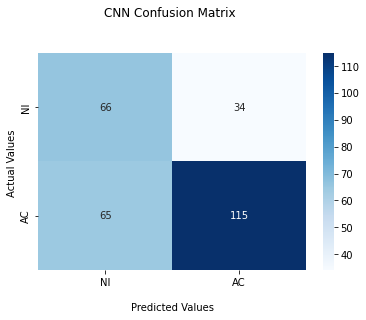

In [13]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

[[ 36  64]
 [ 53 127]]
Accuracy0.5821428571428572


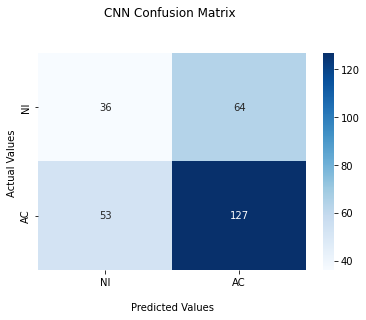

In [213]:
clf_lda, cm_lda = lda_101(tune_tX, tune_tsX, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

CNN

In [15]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_101(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y,
                                                  batch_size = 32,
                                                  epochs = 50)

cnn_models.append(cnn_model)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - ETA: 0s - loss: 2.4811 - accuracy: 0.5370
Epoch 1: val_loss improved from inf to 0.67886, saving model to /tmp/checkpoint.h5
14/14 [==============================] - 29s 2s/step - loss: 2.4811 - accuracy: 0.5370 - val_loss: 0.6789 - val_accuracy: 0.6667
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.8697 - accuracy: 0.5926
Epoch 2: val_loss improved from 0.67886 to 0.65743, saving model to /tmp/checkpoint.h5
14/14 [==============================] - 27s 2s/step - loss: 0.8697 - accuracy: 0.5926 - val_loss: 0.6574 - val_accuracy: 0.6667
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.6921
Epoch 3: val_loss improved from 0.65743 to 0.63189, saving model to /tmp/checkpoint.h5
14/14 [==============================] - 27s 2s/step - loss: 0.6867 - accuracy: 0.6921 - val_loss: 0.6319 - val_accuracy: 0.6667
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.5868 - accuracy

In [16]:
cnn_model.save("cnn_model_1.h5py")

INFO:tensorflow:Assets written to: cnn_model_1.h5py/assets


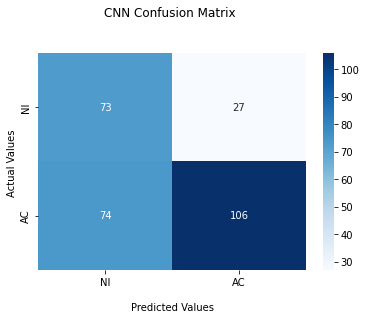

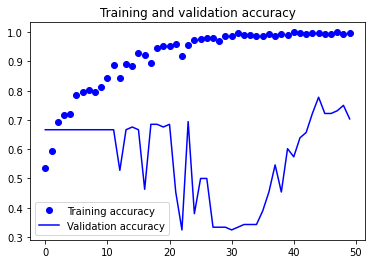

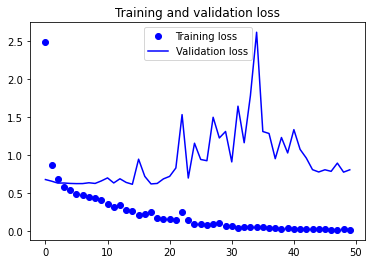

In [17]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [18]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.1557427644729614
Test accuracy: 0.6392857432365417


## LDA & CNN | Subject 2

In [19]:
subject = 1

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.7s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

In [ ]:
test_X.shape

(280, 10, 101)

[[51 49]
 [84 96]]
Accuracy0.525


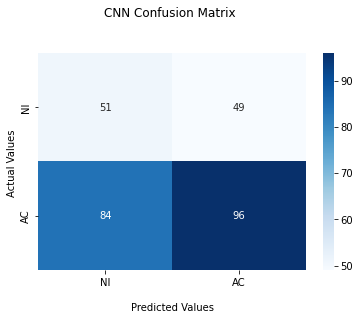

In [20]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

[[ 36  64]
 [ 53 127]]
Accuracy0.5821428571428572


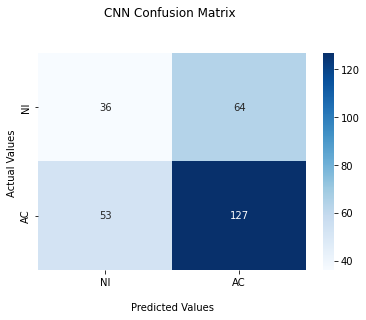

In [208]:
clf_lda, cm_lda = lda_101(tune_tX, tune_tsX, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [21]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_101(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - ETA: 0s - loss: 1.6112 - accuracy: 0.5764
Epoch 1: val_loss improved from inf to 0.68928, saving model to /tmp/checkpoint.h5
14/14 [==============================] - 28s 2s/step - loss: 1.6112 - accuracy: 0.5764 - val_loss: 0.6893 - val_accuracy: 0.6667
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.6736
Epoch 2: val_loss did not improve from 0.68928
14/14 [==============================] - 27s 2s/step - loss: 0.7158 - accuracy: 0.6736 - val_loss: 0.6987 - val_accuracy: 0.3333
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.7176
Epoch 3: val_loss improved from 0.68928 to 0.68514, saving model to /tmp/checkpoint.h5
14/14 [==============================] - 27s 2s/step - loss: 0.5851 - accuracy: 0.7176 - val_loss: 0.6851 - val_accuracy: 0.6667
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7176
Epoch 4: val_loss did not im

In [22]:
cnn_model.save("cnn_model_2.h5py")

INFO:tensorflow:Assets written to: cnn_model_2.h5py/assets


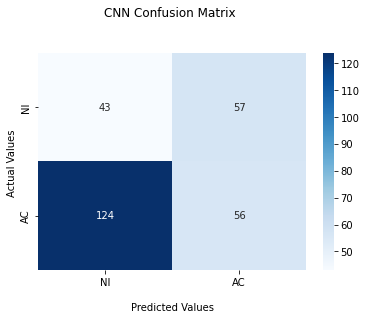

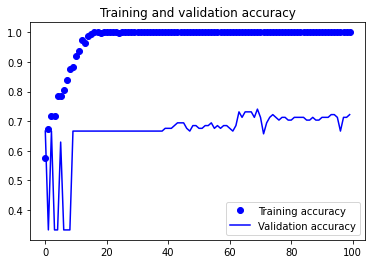

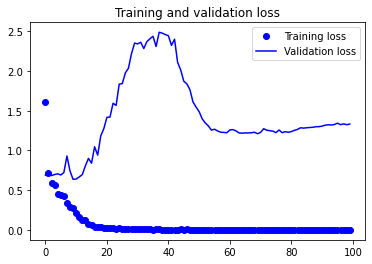

In [23]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

## Test 3: LDA & CNN | Subject 3

In [24]:
subject = 2

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.9s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.2s.


[[43 57]
 [81 69]]
Accuracy0.448


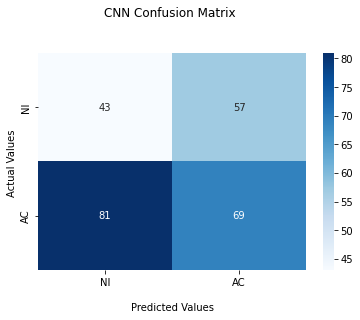

In [25]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

[[40 60]
 [67 83]]
Accuracy0.492


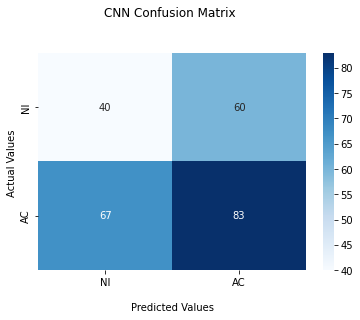

In [ ]:
clf_lda, cm_lda = lda_101(tune_tX, tune_tsX, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [26]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_101(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y, 16 , 50)

cnn_models.append(cnn_model)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


27/27 [==============================] - ETA: 0s - loss: 1.4359 - accuracy: 0.7222
Epoch 1: val_loss improved from inf to 0.84641, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 29s 1s/step - loss: 1.4359 - accuracy: 0.7222 - val_loss: 0.8464 - val_accuracy: 0.2963
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8542
Epoch 2: val_loss did not improve from 0.84641
27/27 [==============================] - 27s 1s/step - loss: 0.3617 - accuracy: 0.8542 - val_loss: 0.8639 - val_accuracy: 0.2963
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.3797 - accuracy: 0.8241
Epoch 3: val_loss did not improve from 0.84641
27/27 [==============================] - 27s 1s/step - loss: 0.3797 - accuracy: 0.8241 - val_loss: 0.8778 - val_accuracy: 0.2963
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8426
Epoch 4: val_loss did not improve from 0.84641
27/27 [=================

In [27]:
cnn_model.save("cnn_model_3.h5py")

INFO:tensorflow:Assets written to: cnn_model_3.h5py/assets


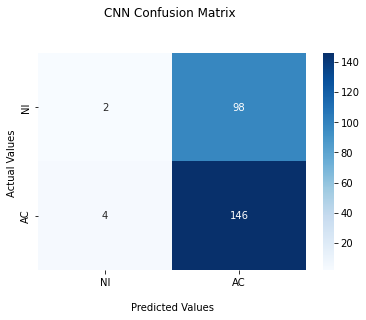

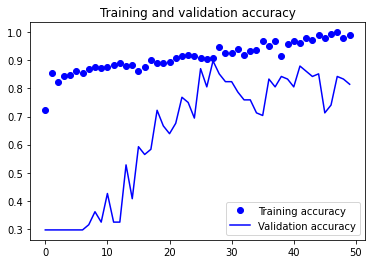

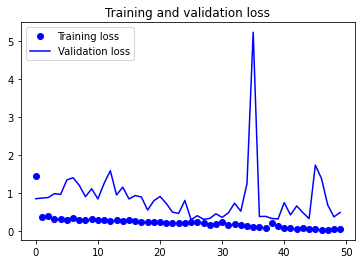

In [28]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [29]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.9669924974441528
Test accuracy: 0.5920000076293945


# Tune Autoencoder

In [287]:
tX, tsX, ty, tsy = train_X.copy(), test_X.copy(), train_y.copy(), test_y.copy()

tAc, _ = raw_to_data(active[0], 2) #active
tNi, _ = raw_to_data(active[0], 1) #ignore

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.0s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

In [288]:
from sklearn.preprocessing import MinMaxScaler
import scipy

scalers = {}
for i in range(tX.shape[1]):
  scalers[i] = MinMaxScaler()
  tX[:, i, :] = sgolay2d(tX[:, i, :], window_size=29, order=0)
  tX[:, i, :] = scalers[i].fit_transform(tX[:, i, :]) 

for i in range(tsX.shape[1]):
  tsX[:, i, :] = sgolay2d(tsX[:, i, :], window_size=29, order=0)
  tsX[:, i, :] = scalers[i].transform(tsX[:, i, :]) 

for i in range(tAc.shape[1]):
  tAc[:, i, :] = sgolay2d(tAc[:, i, :], window_size=29, order=0)
  tAc[:, i, :] = scalers[i].fit_transform(tAc[:, i, :]) 

for i in range(tNi.shape[1]):
  tNi[:, i, :] = sgolay2d(tNi[:, i, :], window_size=29, order=0)
  tNi[:, i, :] = scalers[i].fit_transform(tNi[:, i, :]) 

ValueError: ignored

In [144]:
tAc

array([[[0.38500907, 0.36771269, 0.35146475, ..., 0.        ,
         0.        , 0.        ],
        [0.19350592, 0.18540414, 0.17376624, ..., 0.        ,
         0.        , 0.        ],
        [0.33220116, 0.31466149, 0.29318059, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.33538244, 0.30059472, 0.24913733, ..., 0.        ,
         0.        , 0.        ],
        [0.19144186, 0.17034593, 0.13488856, ..., 0.        ,
         0.        , 0.        ],
        [0.42325775, 0.39814275, 0.36250615, ..., 0.14582529,
         0.14050965, 0.14165154]],

       [[0.42148493, 0.40474292, 0.3877793 , ..., 0.06663047,
         0.06793088, 0.06865711],
        [0.24194773, 0.23364073, 0.22095808, ..., 0.06623024,
         0.06746054, 0.06858191],
        [0.38797089, 0.37027334, 0.34822591, ..., 0.05788903,
         0.05889822, 0.05910216],
        ...,
        [0.30857584, 0.27435348, 0.22444351, ..., 0.0434603 ,
         0.04346619, 0.04314691],
        [0.1

In [289]:
# tAc, _ = raw_to_data(active[0], 2) #active
# tNi, _ = raw_to_data(active[0], 1) #ignore

# scaler = StandardScaler()
# for ch in range(ty.size):
#   scaler.fit(tX[ch])
#   tX[ch] = scaler.transform(tX[ch])
#   if ch < tsy.size:
#     tsX[ch] = scaler.transform(tsX[ch])

#threshold active vs threshold non intention
th_ac = np.zeros([10,101])
th_ni = np.zeros([10,101])
#print(th_ac)

#set threshold
# for n in range(ty.size):
#   if ty[n] == 1:
#     th_ac = th_ac + tX[n]
#   else:
#     th_ni = th_ni + tX[n]

# th_ac = th_ac/np.count_nonzero(ty == 1)
# th_ni = th_ni/np.count_nonzero(ty == 2)

tAc = tAc.reshape(10,-1, 101)
tNi = tNi.reshape(10,-1, 101)

#two thresholds
# th_ac = np.zeros([10, 101])
# th_ni = np.zeros([10, 101])

for ch in range(10):  
  th_ac[ch] = np.mean(tAc[ch], axis = 0)
  th_ni[ch] = np.mean(tNi[ch], axis = 0)

#difference 
#formula |x1 - x2|/((x1 + x2)/2) = 0~1

#sample 
#check true or false 
# true_value = 0
# false_value = 0

dec = np.arange(0.0, 3.1, 0.1)/10
great_value = 0

#save there the end value
tune_tX = np.zeros(tX.shape)

threshold = 0.5
min_threshold = 0.3

for k in dec:
  true_value = 0
  false_value = 0
  not_change = 0
  tmp_tX = np.zeros(tX.shape)
  
  for n in range(ty.size):
    ac = np.absolute(tX[n] - th_ac)/((tX[n] + th_ac)/2)
    ni = np.absolute(tX[n] - th_ni)/((tX[n] + th_ni)/2)

    diff = ac > ni
    true_count = np.count_nonzero(diff == True)
    # print(true_count)

    if true_count/1010 >= threshold + k: #0.6 = 372 0.61=
      tmp_tX[n] = (tX[n] * th_ac)
      # tmp_tX[n] = th_ac
      if ty[n]==2: true_value += 1 
      else: false_value += 1

    elif true_count/1010 < min_threshold + k: 
      tmp_tX[n] = np.negative(tX[n] * th_ni)
      # tmp_tX[n] = (-1)*tmp_tX[n]
      # tmp_tX[n] = th_ni
      if ty[n]==1: true_value += 1 
      else: false_value += 1

    else: 
      tmp_tX[n] = tX[n]
      not_change += 1

  #print((0.5+k), true_value, false_value)

if great_value < true_value:
  great_value = true_value
  threshold += k
  min_threshold += k
  print('new value saved', 0.5+k, true_value, false_value, not_change, 'threshold', threshold)
  tune_tX = tmp_tX

#TEST VALUE
tune_tsX = np.zeros(tsX.shape)
for n in range(tsy.size):
  ac = np.absolute(tsX[n] - th_ac)/((tsX[n] + th_ac)/2)
  ni = np.absolute(tsX[n] - th_ni)/((tsX[n] + th_ni)/2)

  diff = ac > ni
  true_count = np.count_nonzero(diff == True)
  #print(diff)

  if true_count/1010 >= threshold:
    tune_tsX[n] = (tsX[n] * th_ac)
    # tune_tsX[n] = th_ac

  elif true_count/1010 < min_threshold: 
    tune_tsX[n] = np.negative(tsX[n] * th_ni)
    # tune_tsX[n] = (-1)*tune_tsX[n]
    # tune_tsX[n] = th_ni
    # print(n)

  else: 
    tune_tsX[n] = tX[n]


ValueError: ignored

2


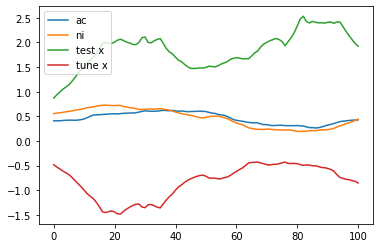

In [210]:
ch = 5
n = 279
print(tsy[n])
plt.plot(th_ac[ch], label = "ac")
plt.plot(th_ni[ch], label = "ni")
plt.plot(tsX[n, ch, :], label = "test x")
plt.plot(tune_tsX[n, ch, :], label = "tune x")
plt.legend()
plt.show()

In [31]:
tAc, _ = raw_to_data(active[0], 2) #active
tNi, _ = raw_to_data(active[0], 1) #ignore

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.8s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

(540, 101)
[[0.42767676 0.42663765 0.41990823 ... 0.27955363 0.28217901 0.2851024 ]
 [0.51975023 0.52100984 0.51809801 ... 0.40177789 0.41414644 0.42113105]
 [0.64611488 0.65635824 0.66183444 ... 0.48707139 0.49668694 0.49962107]
 ...
 [0.43924354 0.44471764 0.44264174 ... 0.43964737 0.4403302  0.44237442]
 [0.27919097 0.2831596  0.28221681 ... 0.36268622 0.36608652 0.36811399]
 [0.39889199 0.40653159 0.41107821 ... 0.45664198 0.46309655 0.46508958]] [[-0.42767676 -0.42663765 -0.41990823 ... -0.27955363 -0.28217901
  -0.2851024 ]
 [-0.51975023 -0.52100984 -0.51809801 ... -0.40177789 -0.41414644
  -0.42113105]
 [-0.64611488 -0.65635824 -0.66183444 ... -0.48707139 -0.49668694
  -0.49962107]
 ...
 [-0.43924354 -0.44471764 -0.44264174 ... -0.43964737 -0.4403302
  -0.44237442]
 [-0.27919097 -0.2831596  -0.28221681 ... -0.36268622 -0.36608652
  -0.36811399]
 [-0.39889199 -0.40653159 -0.41107821 ... -0.45664198 -0.46309655
  -0.46508958]]


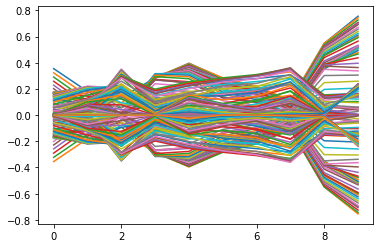

In [183]:
print(tX[:, 1, :].shape)
tAc.reshape(10,-1, 101).shape
tmp = th_ac.copy()
print(tmp, tmp*(-1))

plt.plot(tX[0])
plt.plot(tX[0]*(-1))
plt.show()

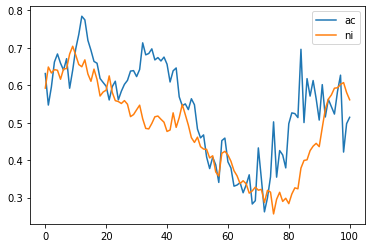

In [59]:
tAc = tAc.reshape(10,-1, 101)
tNi = tNi.reshape(10,-1, 101)
th_ac = np.zeros([10, 101])
th_ni = np.zeros([10, 101])

for ch in range(10):
  th_ac[ch] = np.mean(tAc[ch], axis = 0)
  th_ni[ch] = np.mean(tNi[ch], axis = 0)



plt.plot(th_ac[0], label = "ac")
plt.plot(th_ni[0], label = "ni")
plt.legend()
plt.show()



In [45]:
th_ac.shape

(10, 101)

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

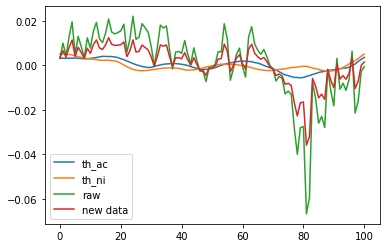

In [106]:
k = 3
m = 123
data_ac = th_ac.copy()
data_ni = th_ni.copy()

# data_ac = np.squeeze(tmp_ac[k,:]) # Shape is now: (10, 80)

# data_ni = np.squeeze(tmp_ni[k, :]) # Shape is now: (10, 80)

# data_raw = np.squeeze(tX[m, k, :]) # Shape is now: (10, 80)
print(ty[m])

data_ac[k] = savitzky_golay(data_ac[k], window_size=29, order=4)
data_ni[k] = savitzky_golay(data_ni[k], window_size=29, order=4)

if ty[m] == 1: 
  after_tune = (tX[m] + data_ac)/2
else: 
  after_tune = (tX[m] + data_ni)/2



plt.plot(data_ac[k], label="th_ac")
plt.plot(data_ni[k], label="th_ni")
plt.plot(tX[m, k, :], label="raw")
plt.plot(after_tune[k, :], label="new data") # plotting by columns
plt.legend()
plt.show()

In [76]:
ac, _ = raw_to_data(active[0], 0)
pas, _ = raw_to_data(passive[0], 1)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.6s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

(101,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

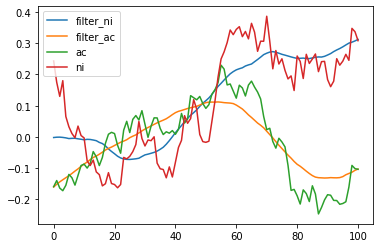

In [101]:
plt_ac = np.mean(ac[:,4,:], axis =0)*100
plt_ni = np.mean(pas[:,1,:], axis =0)*100

z = plt_ac
print(z.shape)

plt_ac_sg = savitzky_golay(z, window_size=35, order=0)
plt_ni_sg = savitzky_golay(plt_ni, window_size=35, order=0)

plt.plot(plt_ni_sg, label = "filter_ni")
plt.plot(plt_ac_sg, label = "filter_ac")
plt.plot(plt_ac, label = "ac")
plt.plot(plt_ni, label = "ni")
plt.legend()
plt.show()

In [80]:
plt_ac.shape

(101,)

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv2D(8, kernel_size=(4, 40),activation='relu',input_shape=(10,101,1),padding='same'))
# cnn_model.add(MaxPooling2D((2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(16, (4, 80), activation='relu',padding='same'))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (4, 80), activation='relu',padding='same'))         
# cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.3))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(2, activation='sigmoid'))

cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 10, 101, 8)        1288      
                                                                 
 batch_normalization_46 (Bat  (None, 10, 101, 8)       32        
 chNormalization)                                                
                                                                 
 dropout_54 (Dropout)        (None, 10, 101, 8)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 10, 101, 16)       40976     
                                                                 
 batch_normalization_47 (Bat  (None, 10, 101, 16)      64        
 chNormalization)                                                
                                                                 
 dropout_55 (Dropout)        (None, 10, 101, 16)     

In [74]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')        

In [81]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# DeepEEG

In [263]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   


def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)


In [277]:
model = ShallowConvNet(nb_classes = 2, Chans = 10, Samples = 101)

In [285]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
# train_y = np_utils.to_categorical(train_y-1)
test_y = np_utils.to_categorical(test_y-1)

train_X = train_X.reshape(-1, 10,101, 1)
test_X = test_X.reshape(-1, 10,101, 1)

train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                            train_y, 
                                                            test_size=0.2, 
                                                            random_state=13)

train_label_categorical = np_utils.to_categorical(train_label-1)
valid_label_categorical = np_utils.to_categorical(valid_label-1)

fittedModel = model.fit(train_X, train_label_categorical, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(valid_X, valid_label_categorical))


Epoch 1/300
27/27 - 1s - loss: 0.6430 - val_loss: 0.6093 - 1s/epoch - 43ms/step
Epoch 2/300
27/27 - 0s - loss: 0.4800 - val_loss: 0.6354 - 424ms/epoch - 16ms/step
Epoch 3/300
27/27 - 0s - loss: 0.4429 - val_loss: 0.6564 - 390ms/epoch - 14ms/step
Epoch 4/300
27/27 - 0s - loss: 0.4021 - val_loss: 0.6706 - 412ms/epoch - 15ms/step
Epoch 5/300
27/27 - 0s - loss: 0.3870 - val_loss: 0.5725 - 395ms/epoch - 15ms/step
Epoch 6/300
27/27 - 0s - loss: 0.3639 - val_loss: 0.6241 - 402ms/epoch - 15ms/step
Epoch 7/300
27/27 - 0s - loss: 0.3266 - val_loss: 0.6733 - 402ms/epoch - 15ms/step
Epoch 8/300
27/27 - 0s - loss: 0.3624 - val_loss: 0.6306 - 403ms/epoch - 15ms/step
Epoch 9/300
27/27 - 0s - loss: 0.3226 - val_loss: 0.7084 - 407ms/epoch - 15ms/step
Epoch 10/300
27/27 - 0s - loss: 0.3270 - val_loss: 0.9332 - 395ms/epoch - 15ms/step
Epoch 11/300
27/27 - 0s - loss: 0.2918 - val_loss: 0.6019 - 402ms/epoch - 15ms/step
Epoch 12/300
27/27 - 0s - loss: 0.2884 - val_loss: 0.9955 - 406ms/epoch - 15ms/step
Epoc

In [286]:
probs       = model.predict(test_X)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == test_y.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.460714 
